**Comprehensive, Multi-Source Cyber-Security Events**

This data set represents 58 consecutive days of de-identified event data collected from five sources within Los Alamos National Laboratory’s corporate, internal computer network.

The data sources include Windows-based authentication events from both individual computers and centralized Active Directory domain controller servers; process start and stop events from individual Windows computers; Domain Name Service (DNS) lookups as collected on internal DNS servers; network flow data as collected on at several key router locations; and a set of well-defined red teaming events that present bad behavior within the 58 days. In total, the data set is approximately 12 gigabytes compressed across the five data elements and presents 1,648,275,307 events in total for 12,425 users, 17,684 computers, and 62,974 processes.

Specific users that are well known system related (SYSTEM, Local Service) were not de-identified though any well-known administrators account were still de-identified. In the network flow data, well-known ports (e.g. 80, 443, etc) were not de-identified. All other users, computers, process, ports, times, and other details were de-identified as a unified set across all the data elements (e.g. U1 is the same U1 in all of the data). The specific timeframe used is not disclosed for security purposes. In addition, no data that allows association outside of LANL’s network is included. All data starts with a time epoch of 1 using a time resolution of 1 second. In the authentication data, failed authentication events are only included for users that had a successful authentication event somewhere within the data set.


A. D. Kent, "Cybersecurity Data Sources for Dynamic Network Research,"
in Dynamic Networks in Cybersecurity, 2015.

# plan

1. get basic eda for red team
2. basic feature stats for auth file
3. collect dfs for blocked users
4. take red team user, all his events and do basic investigation there

# imports, consts, funcs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from itertools import islice
from collections import Counter 

In [2]:
def auth_type_lambda(x):
  if x.startswith('MICROSOFT_AUTHENTICATION_PACKAGE_V'):
    return 'MICROSOFT_AUTHENTICATION_PACKAGE_V1'.replace('_', ' ').lower().replace('authentication', 'auth')
  elif x.startswith('MICROSOFT_AUTHENTICATION'):
    return 'MICROSOFT_AUTHENTICATION_PACKAGE'.replace('_', ' ').lower().replace('authentication', 'auth')
  else:
    return x.replace('_', ' ').lower().replace('authentication', 'auth')

def extract_fields_from_line(line_list):
    time = int(line_list[0][2:])
    source_user, destination_user, source_computer, destination_computer, authentication_type, logon_type, authentication_orientation  = line_list[1:-1]
    success_failure = line_list[-1][:-1]
    authentication_type = auth_type_lambda(authentication_type)

    return time, source_user, destination_user, source_computer, destination_computer, authentication_type, logon_type, authentication_orientation, success_failure

extract_fields_from_line(["b'1", 'C101$@DOM1', 'C101$@DOM1', 'C988', 'C988', 'MICROSOFT_AUTHENTICATION_PACKAGE_V6', 'Network', 'LogOff', "Success'"])

(1,
 'C101$@DOM1',
 'C101$@DOM1',
 'C988',
 'C988',
 'microsoft auth package v1',
 'Network',
 'LogOff',
 'Success')

In [3]:
def plot_bar_for_dict(dictionary, title, to_normalize = False):

    plt.figure()
    if to_normalize:
        normalized_dictionary = {dictionary_key : 100 * dictionary_value / sum(dictionary.values()) for dictionary_key, dictionary_value in dictionary.items()}
    else:
        normalized_dictionary = dictionary
    names_dictionary, counts_dictionary = zip(*normalized_dictionary.items())
    plt.bar(names_dictionary, counts_dictionary)
    plt.xticks(rotation=75)
    plt.ylabel('%')
    plt.title(title)
    plt.show()

In [4]:
USER_BLACK_LIST = ["SYSTEM", "ANONYMOUS LOGON", "LOCAL SERVICE", "NETWORK SERVICE"]
MAX_NUM_LINES = int(1e8)
AUTH_COLUMNS =['time', 'source_user_at_domain','destination_user_at_domain',
                              'source_computer','destination_computer','authentication_type',
                              'logon_type','authentication_orientation','success_failure']

In [143]:
def normalize_dict(d):
    denominator = sum([d[x] for x in d.keys()])
    normalized_d = {x : d[x] / denominator for x in d.keys()}
    return normalized_d

normalize_dict({'a': 1, 'b': 3})

{'a': 0.25, 'b': 0.75}

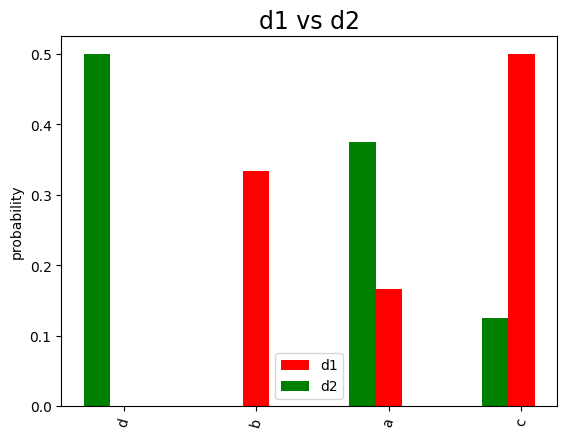

In [189]:
d1 = {'a': 1, 'b': 2, 'c': 3}
d2 = {'a': 3, 'c': 1, 'd': 4}

def align_plot_two_dicts(d1, d2, d1_name, d2_name, plot_title):
  # align with keys
  all_keys = set(d1.keys()).union(set(d2.keys()))
  full_d1 = dict()
  full_d2 = dict()
  for all_key in all_keys:
    full_d1[all_key] = d1.get(all_key, 0) 
    full_d2[all_key] = d2.get(all_key, 0) 

  X = np.arange(len(full_d1))
  ax = plt.subplot(111)
  ax.bar(X, full_d1.values(), width=0.2, color='r', align='center')
  ax.bar(X-0.2, full_d2.values(), width=0.2, color='g', align='center')
  ax.legend((d1_name, d2_name))
  plt.xticks(X, all_keys, rotation = 75)
  plt.title(plot_title, fontsize=17)
  plt.ylabel('probability')
  plt.show()

align_plot_two_dicts(normalize_dict(d1), normalize_dict(d2), d1_name = 'd1', d2_name='d2', plot_title='d1 vs d2')

# red team basic eda

This data presents specific events taken from the authentication data that present known redteam compromise events. These may be used as ground truth of bad behavior that is different from normal user and computer activity. Each event is on a separate line in the form of “time,user@domain,source computer,destination computer” and presents a compromise event at the given time

In [5]:
with gzip.open('redteam.txt.gz', 'rb') as f:
    file_content = f.readlines()

lines = [x.strip() for x in file_content]
lines_for_pd = [str(x).split(',') for x in lines]

red_team = pd.DataFrame(lines_for_pd, columns=['time', 'user_at_domain', 'source_computer', 'destination_computer'])
red_team['time'] = red_team['time'].apply(lambda x: int(x.replace("b\'", "")))
red_team['destination_computer'] = red_team['destination_computer'].apply(lambda x: x[:-1])
red_team[['user', 'domain']] = red_team.user_at_domain.str.split('@', expand=True)
red_team = red_team.sort_values(['time', 'user_at_domain'])

print('First few rows of red team df:')
display(red_team.head(3))

First few rows of red team df:


,time,user_at_domain,source_computer,destination_computer,user,domain
0,150885,U620@DOM1,C17693,C1003,U620,DOM1
1,151036,U748@DOM1,C17693,C305,U748,DOM1
2,151648,U748@DOM1,C17693,C728,U748,DOM1


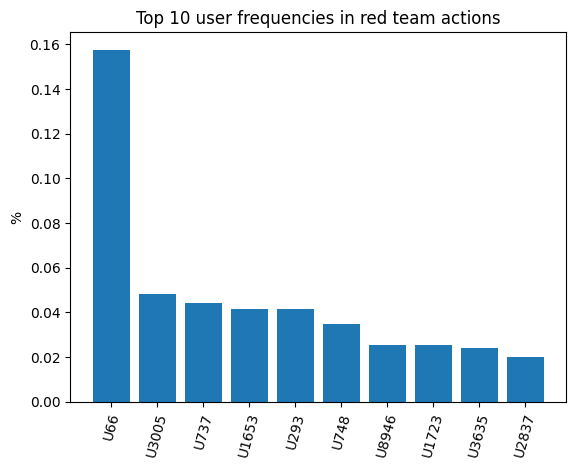

Overall we have 98 unique users or 104 user_at_domains


In [6]:
# how many: unique domains. users, distribution of source computers and destination computers
top_k = 10
user_value_counts = red_team.user.value_counts(normalize=True).head(top_k).to_dict()
plot_bar_for_dict(user_value_counts, title = f'Top {top_k} user frequencies in red team actions')
print(f'Overall we have {red_team.user.nunique()} unique users or {red_team.user_at_domain.nunique()} user_at_domains')

In [7]:
users_with_many_domains = red_team.groupby('user')['domain'].agg(['unique'])
users_with_many_domains['n_domains'] = users_with_many_domains['unique'].apply(lambda x: len(x))
users_with_many_domains = users_with_many_domains[users_with_many_domains.n_domains != 1].sort_values('n_domains', ascending=False)
print('Users that have multiple domains:')
display(users_with_many_domains)

Users that have multiple domains:


,unique,n_domains
user,,
U8777,"[C583, C1500, C3388, DOM1]",4
U737,"[DOM1, C10]",2
U8168,"[C19038, C685]",2
U86,"[C10, DOM1]",2


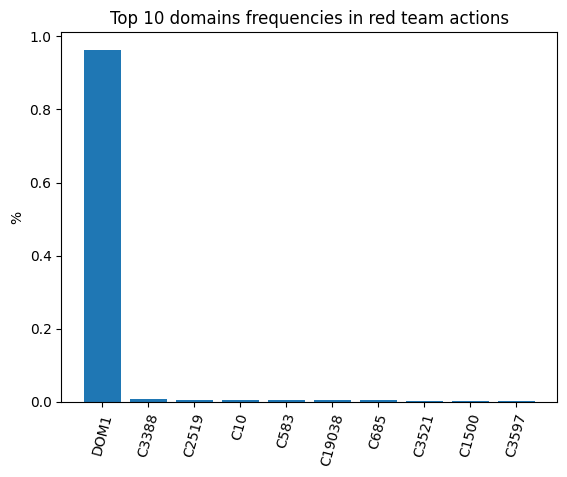

Overall we have 10 unique domains


In [8]:
top_k = 10
domains_value_counts = red_team.domain.value_counts(normalize=True).head(top_k).to_dict()
plot_bar_for_dict(domains_value_counts, title = f'Top {top_k} domains frequencies in red team actions')

print(f'Overall we have {red_team.domain.nunique()} unique domains')

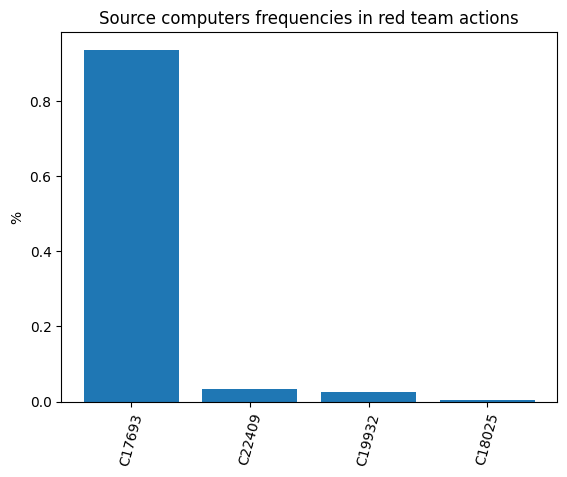

In [9]:
source_computers_value_counts = red_team.source_computer.value_counts(normalize=True).to_dict()
plot_bar_for_dict(source_computers_value_counts, title = f'Source computers frequencies in red team actions')

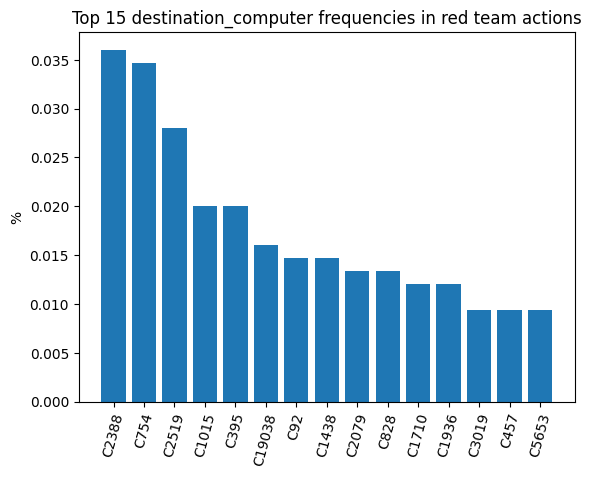

Overall we have 301 unique destination computers


In [10]:
top_k = 15
destination_computers_value_counts = red_team.destination_computer.value_counts(normalize=True).head(top_k).to_dict()
plot_bar_for_dict(destination_computers_value_counts, title = f'Top {top_k} destination_computer frequencies in red team actions')

print(f'Overall we have {red_team.destination_computer.nunique()} unique destination computers')

Text(0.5, 1.0, 'Number of events in time')

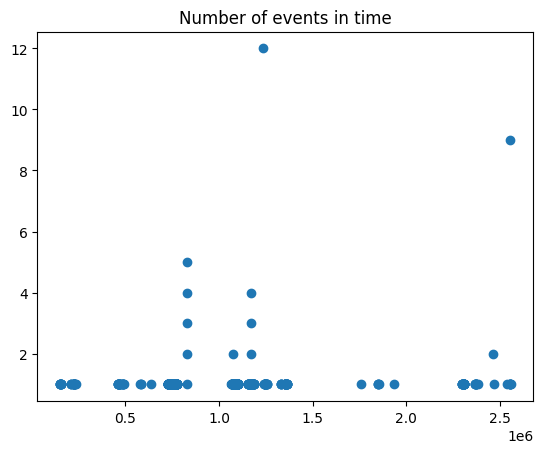

In [11]:
# time span
number_events_in_time = red_team.time.value_counts().to_dict()
time_keys = sorted(number_events_in_time.keys())
plt.figure()
plt.scatter(x = time_keys, y = [number_events_in_time[time_key] for time_key in time_keys])
plt.title('Number of events in time')

In [12]:
# how often same source and destination computers
print('Fraction of cases when source computer is same as destination computer:')
red_team['is_remote'] = red_team.source_computer != red_team.destination_computer
display(red_team.is_remote.value_counts(normalize=True))

Fraction of cases when source computer is same as destination computer:


is_remote
True    1.0
Name: proportion, dtype: float64

In [13]:
# when domain is not DOM1, is it equal to source or destination computer?
not_dom1 = red_team[red_team.domain != 'DOM1'].copy()
not_dom1['domain_is_source_pc'] = not_dom1.domain == not_dom1.source_computer
not_dom1['domain_is_destination_pc'] = not_dom1.domain == not_dom1.destination_computer
print('When domain is not DOM1, is it equal to source pc pr destination pc or none of them?')
display(not_dom1.groupby(['domain_is_source_pc', 'domain_is_destination_pc'])['user'].size())

When domain is not DOM1, is it equal to source pc pr destination pc or none of them?


domain_is_source_pc  domain_is_destination_pc
False                True                        27
Name: user, dtype: int64

In [66]:
red_team_dict = {(time, user) : (source_pc, dest_pc)
                for time, user, source_pc, dest_pc in zip(red_team.time, red_team.user_at_domain, red_team.source_computer, red_team.destination_computer)}

red_team_dict[(150885, 'U620@DOM1')]

('C17693', 'C1003')

**First conclusions on red team data**

1. Always remote: source and destination computer are never the same
2. Same source and destination user
3. Few source computers and many destinations
4. In most cases user domain is DOM1, and otherwise it's the same as destination computer!
5. Nature of attack is simple: a compromised user just logons to various computers

# basic feature stats for auth file


with additional questions: 

1. how often same user/same computer/same user_at_domain?
2. how often same source/dest computer and same source/dest user?
3. if source domain != DOM1, then how often it's not source computer?
4. event/computer/user count per hour/day

**Authentications**

This data represents authentication events collected from individual Windows-based desktop computers, servers, and Active Directory servers. Each event is on a separate line in the form of “time,source user@domain,destination user@domain,source computer,destination computer,authentication type,logon type,authentication orientation,success/failure” and represents an authentication event at the given time. The values are comma delimited and any fields that do not have a valid value are represented as a question mark ('?').

In [126]:
# 1. how often same user/same computer/same user_at_domain?
# 2. how often same source/dest computer and same source/dest user?

authentication_type_counter = Counter(dict())
logon_type_counter = Counter(dict())
authentication_orientation_counter = Counter(dict())
success_counter = Counter(dict())
same_source_destination_by_orientation = Counter(dict())
source_domains_counter = Counter(dict())
source_domains_types_counter = Counter(dict()) # source domain can be of type: 1)DOMx, 2)Cy or 3)something else
dom_type_source_domains_counter = Counter(dict())
other_source_domains_counter = Counter(dict())

is_same_user = 0
is_same_computer = 0 # same as is remote
is_same_user_computer_and_logon = 0
is_source_domain_equal_destination_computer_if_not_dom = 0
is_source_domain_equal_source_computer_if_not_dom = 0
not_dom1 = 0
num_lines = 0

with gzip.open('auth.txt.gz') as f:
    for line in f:
        line = line.strip()
        line = str(line).split(',')
        # extract columns: computers, users, time
        time, source_user, destination_user, source_computer, destination_computer, authentication_type, logon_type, authentication_orientation, success_failure = extract_fields_from_line(line)
        source_domain = source_user.split('@')[1]
        if source_domain.startswith('C'):
            source_domain_type = 'physical computer'
        elif source_domain.startswith('DOM'):
            source_domain_type = 'DOM'
        else:
            source_domain_type = 'other'
            other_source_domains_counter.update({source_domain : 1})
        # update counters
        num_lines += 1
        authentication_type_counter.update({authentication_type : 1})
        logon_type_counter.update({logon_type : 1})
        authentication_orientation_counter.update({authentication_orientation : 1})
        success_counter.update({success_failure : 1})
        source_domains_counter.update({source_domain : 1})
        source_domains_types_counter.update({source_domain_type: 1})
        if source_domain_type == 'DOM':
            dom_type_source_domains_counter.update({int(source_domain[3:]) : 1})
        else:
            if source_computer != destination_computer:
                not_dom1 += 1
                is_source_domain_equal_destination_computer_if_not_dom += int(source_domain == destination_computer)
                is_source_domain_equal_source_computer_if_not_dom += int(source_domain == source_computer)
        
        is_same_user += int(source_user == destination_user)
        is_same_computer += int(source_computer == destination_computer)
        same_source_destination_by_orientation.update({authentication_orientation : int(source_user == destination_user and source_computer == destination_computer)})
        # if exceeded number of lines, break
        if num_lines >= MAX_NUM_LINES:
            break

print(f'Parsed {num_lines} first rows in the auth text file')
print(f'\nAverage is_same_user_at_domain: {is_same_user / num_lines}, average is_same_computer: {is_same_computer/num_lines}')
print(f'\nWhen source domain is not like DOM% and source and destination computers are different, \
then source domain is equal to source computer in \
{round(100 * is_source_domain_equal_source_computer_if_not_dom/ not_dom1, 2)}% cases \
and to destination computer in \
{round(100 * is_source_domain_equal_destination_computer_if_not_dom/ not_dom1, 2)}% cases.')

Parsed 100000000 first rows in the auth text file

Average is_same_user_at_domain: 0.98493273, average is_same_computer: 0.5415954

When source domain is not like DOM% and source and destination computers are different, then source domain is equal to source computer in 0.68% cases and to destination computer in 99.11% cases.


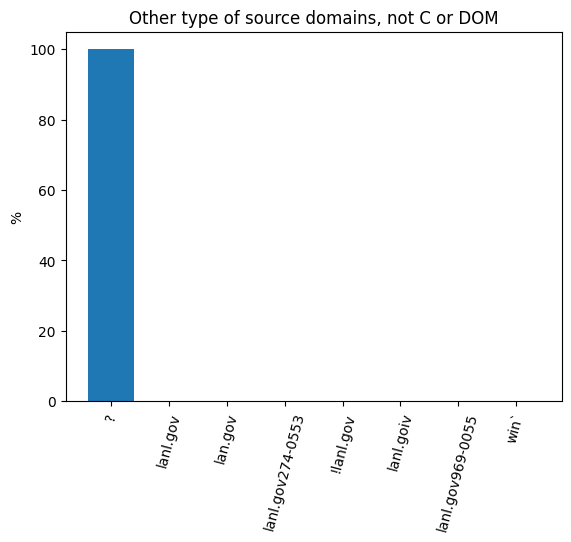

In [127]:
plot_bar_for_dict(other_source_domains_counter, title = 'Other type of source domains, not C or DOM', to_normalize=True)

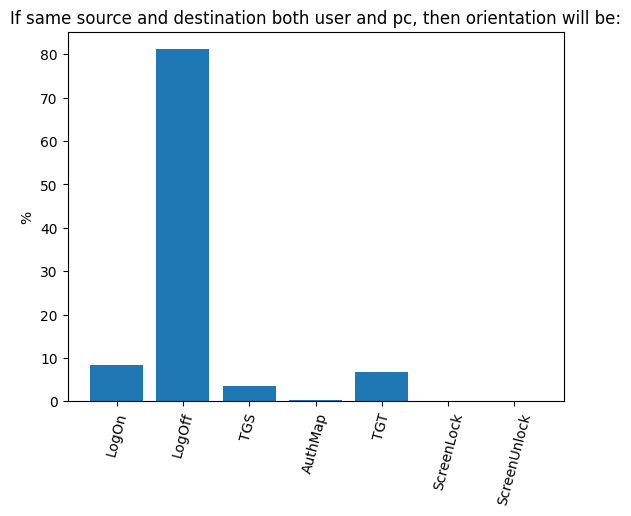

In [128]:
plot_bar_for_dict(same_source_destination_by_orientation, 
                  title = 'If same source and destination both user and pc, then orientation will be:',
                  to_normalize=True)

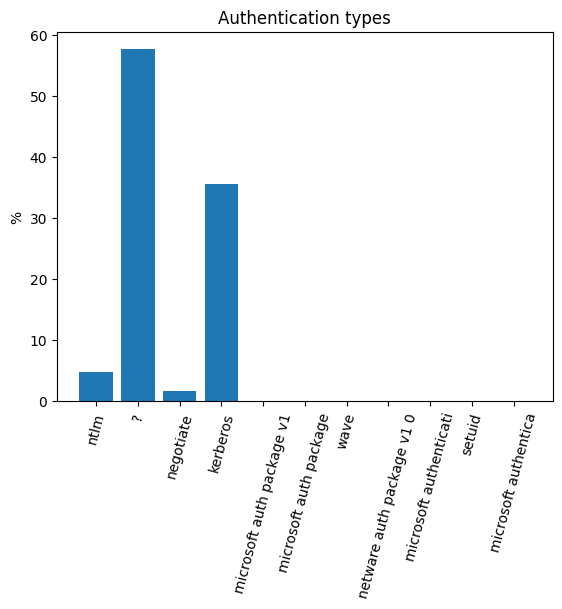

Unique values for authentication type: dict_keys(['ntlm', '?', 'negotiate', 'kerberos', 'microsoft auth package v1', 'microsoft auth package', 'wave', 'netware auth package v1 0', 'microsoft authenticati', 'setuid', 'microsoft authentica'])


In [129]:
plot_bar_for_dict(authentication_type_counter, title = f'Authentication types', to_normalize=True)
print(f'Unique values for authentication type: {authentication_type_counter.keys()}')

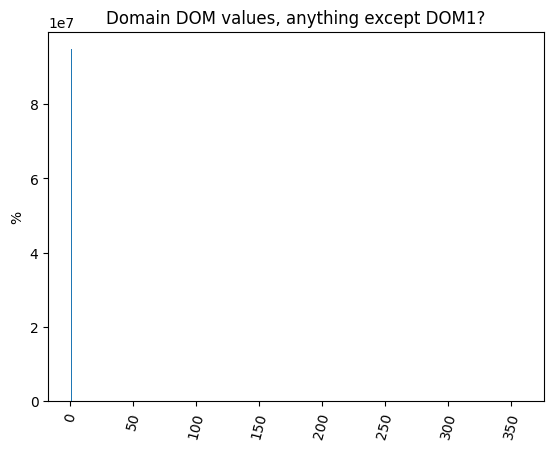

In [130]:
plot_bar_for_dict(dom_type_source_domains_counter, title = 'Domain DOM values, anything except DOM1?')

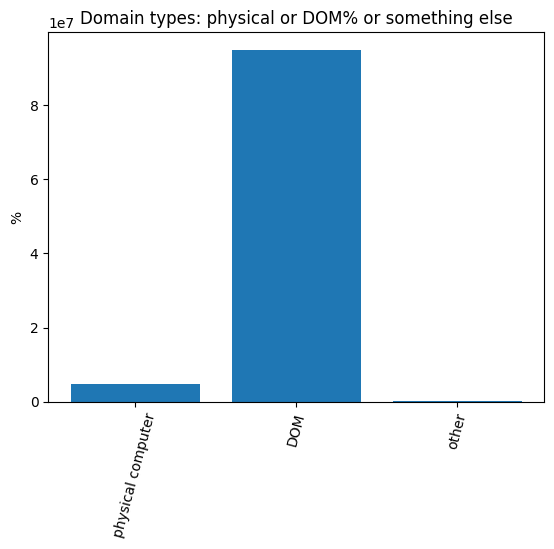

Counter({'DOM': 94977927, 'physical computer': 4775577, 'other': 246496})


In [123]:
plot_bar_for_dict(source_domains_types_counter, title = 'Domain types: physical or DOM% or something else')
print(source_domains_types_counter)

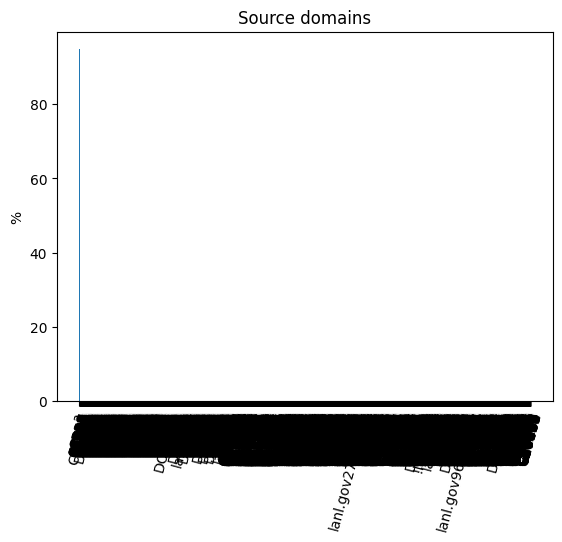

Unique values for 9353 source domains: ['C586', 'DOM1', 'C2493', 'DOM3', 'C1504']...


In [108]:
plot_bar_for_dict(source_domains_counter, title = f'Source domains', to_normalize=True)
print(f'Unique values for {len(source_domains_counter.keys())} source domains: {list(source_domains_counter.keys())[:5]}...')

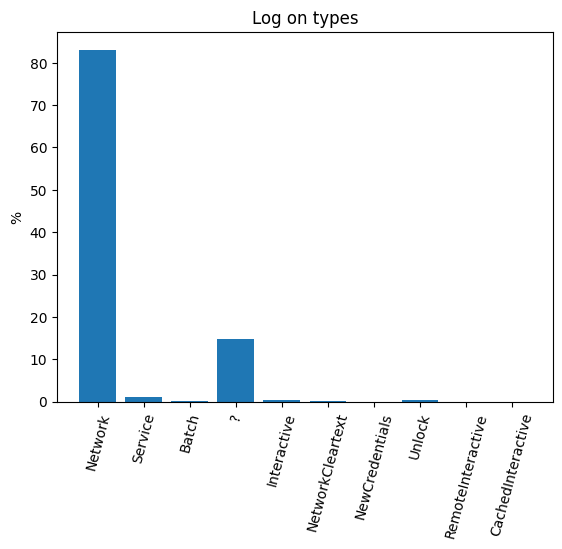

In [109]:
plot_bar_for_dict(logon_type_counter, title = f'Log on types', to_normalize=True)

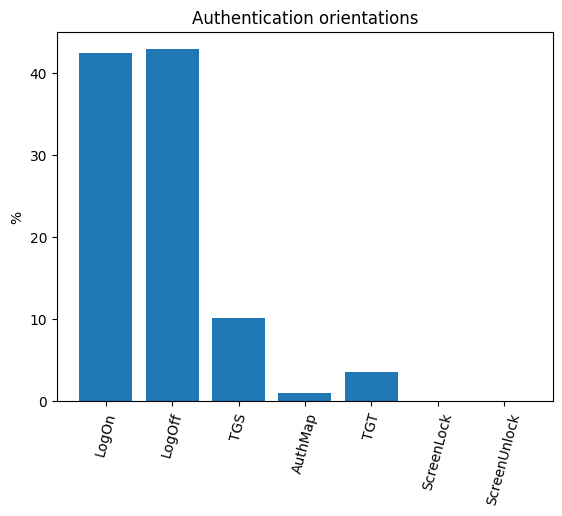

In [110]:
plot_bar_for_dict(authentication_orientation_counter, title = f'Authentication orientations', to_normalize=True)

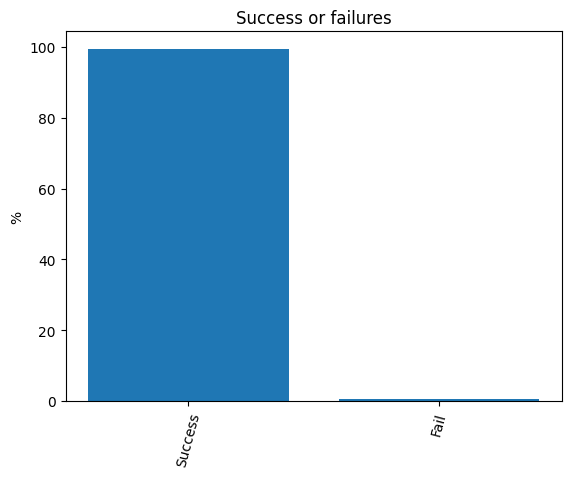

In [111]:
plot_bar_for_dict(success_counter, title = f'Success or failures', to_normalize=True)

In [38]:
hour_event_counter = Counter(dict())
day_event_counter = Counter(dict())
n_lines = 0
# event/computer/user count per hour/day
with gzip.open('auth.txt.gz') as f:
    for line in f:
        line = line.strip()
        line = str(line).split(',')
        # extract columns: computers, users, time
        time, source_user, destination_user, source_computer, destination_computer, authentication_type, logon_type, authentication_orientation, success_failure = extract_fields_from_line(line)
        # what hour is it
        hour = time // (60 * 60)
        hour24 = int(hour) % 24
        # what day is it
        day = int(hour) // 24
        day7 = day % 7
        # update event Counter for day & hour
        hour_event_counter.update({hour : 1})
        day_event_counter.update({day: 1})

        # stop at some point
        n_lines += 1
        if n_lines >= 5e8:
            print(f'Hours range from 0 to {hour}, days range from 0 to {day}')
            max_hour = hour
            max_day = day
            break


Hours range from 0 to 708, days range from 0 to 29


Hours range from 0 to 1335, days range from 0 to 55


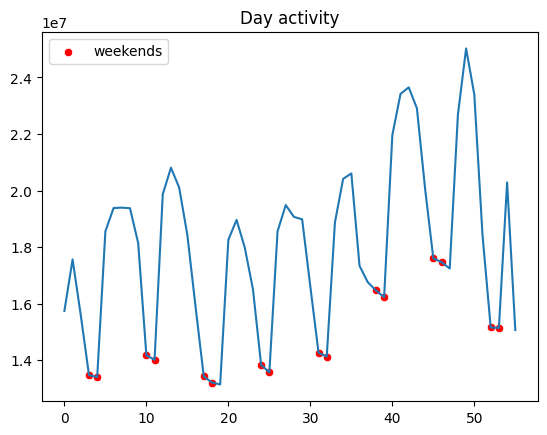

In [78]:
hour_event_counter = Counter(dict())
day_event_counter = Counter(dict())
n_lines = 0
# event/computer/user count per hour/day
with gzip.open('auth.txt.gz') as f:
    for line in f:
        line = line.strip()
        line = str(line).split(',')
        # extract columns: computers, users, time
        time, source_user, destination_user, source_computer, destination_computer, authentication_type, logon_type, authentication_orientation, success_failure = extract_fields_from_line(line)
        # what hour is it
        hour = time // (60 * 60)
        hour24 = int(hour) % 24
        # what day is it
        day = int(hour) // 24
        day7 = day % 7
        # update event Counter for day & hour
        hour_event_counter.update({hour : 1})
        day_event_counter.update({day: 1})

        # stop at some point
        n_lines += 1
        if n_lines >= 1e9:
            print(f'Hours range from 0 to {hour}, days range from 0 to {day}')
            max_hour = hour
            max_day = day
            break
            
plt.figure()
sns.lineplot(x = range(max_day + 1), y = [day_event_counter[day] for day in range(max_day + 1)], markers=True)
weekends = list(np.arange(3, max_day + 1, 7)) + list(np.arange(4, max_day + 1, 7))
weekends = sorted(weekends)
sns.scatterplot(x = weekends, y = [day_event_counter[day] for day in weekends], color = 'red', label = 'weekends')
plt.legend()
plt.title('Day activity');

Text(0.5, 1.0, 'Hour activity')

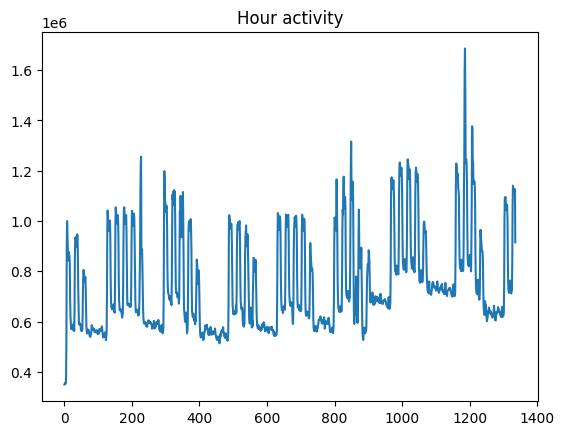

In [81]:
plt.figure()
sns.lineplot(x = range(max_hour + 1), y = [hour_event_counter[hour] for hour in range(max_hour + 1)])
plt.title('Hour activity')

# collect dfs for blocked users

In [35]:
USER_BLACK_LIST

['SYSTEM', 'ANONYMOUS LOGON', 'LOCAL SERVICE', 'NETWORK SERVICE']

In [16]:
lines_for_blocked_users = {blocked_user : [] for blocked_user in USER_BLACK_LIST}
n_lines = 0
with gzip.open('auth.txt.gz') as f:
    for line in f:
        line = line.strip()
        line = str(line).split(',')
        # extract columns: computers, users, time
        time, source_user, destination_user, source_computer, destination_computer, authentication_type, logon_type, authentication_orientation, success_failure = extract_fields_from_line(line)
        if source_user.split('@')[0] in USER_BLACK_LIST and len(lines_for_blocked_users[source_user.split('@')[0]]) <= int(1e5):
            n_lines += 1
            block_user_line = [time, source_user, destination_user, 
                               source_computer, destination_computer, 
                               authentication_type, logon_type, 
                               authentication_orientation, success_failure]
            lines_for_blocked_users[source_user.split('@')[0]].append(block_user_line)
            if n_lines >= len(USER_BLACK_LIST) * 1e5:
                break
        else:
            continue

In [17]:
for blocked_user in USER_BLACK_LIST:
    print(f'\n\nBlocked user {blocked_user}, found {len(lines_for_blocked_users[blocked_user])} rows for this user as source user, for example:')
    df_for_blocked_user = pd.DataFrame(lines_for_blocked_users[blocked_user], 
                                       columns=AUTH_COLUMNS)
    display(df_for_blocked_user.head(5))



Blocked user SYSTEM, found 99997 rows for this user as source user, for example:


,time,source_user_at_domain,destination_user_at_domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success_failure
0,13,SYSTEM@C395,C395$@DOM1,C395,C395,?,?,AuthMap,Success
1,18,SYSTEM@C561,SYSTEM@C561,C561,C561,?,NewCredentials,LogOff,Success
2,20,SYSTEM@C1500,C1500$@DOM1,C1500,C1500,?,?,AuthMap,Success
3,25,SYSTEM@C4169,SYSTEM@C4169,C4169,C4169,negotiate,NewCredentials,LogOn,Fail
4,26,SYSTEM@C1500,C1500$@DOM1,C1500,C1500,?,?,AuthMap,Success




Blocked user ANONYMOUS LOGON, found 100001 rows for this user as source user, for example:


,time,source_user_at_domain,destination_user_at_domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success_failure
0,1,ANONYMOUS LOGON@C586,ANONYMOUS LOGON@C586,C1250,C586,ntlm,Network,LogOn,Success
1,1,ANONYMOUS LOGON@C586,ANONYMOUS LOGON@C586,C586,C586,?,Network,LogOff,Success
2,2,ANONYMOUS LOGON@C1529,ANONYMOUS LOGON@C1529,C1529,C1529,?,Network,LogOff,Success
3,2,ANONYMOUS LOGON@C457,ANONYMOUS LOGON@C457,C4615,C457,ntlm,Network,LogOn,Success
4,2,ANONYMOUS LOGON@C586,ANONYMOUS LOGON@C586,C2734,C586,ntlm,Network,LogOn,Success




Blocked user LOCAL SERVICE, found 100001 rows for this user as source user, for example:


,time,source_user_at_domain,destination_user_at_domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success_failure
0,1,LOCAL SERVICE@C2493,LOCAL SERVICE@C2493,C2493,C2493,negotiate,Service,LogOn,Success
1,15,LOCAL SERVICE@C1864,LOCAL SERVICE@C1864,C1864,C1864,negotiate,Service,LogOn,Success
2,17,LOCAL SERVICE@C4515,LOCAL SERVICE@C4515,C4515,C4515,negotiate,Service,LogOn,Success
3,21,LOCAL SERVICE@C4466,LOCAL SERVICE@C4466,C4466,C4466,negotiate,Service,LogOn,Success
4,25,LOCAL SERVICE@C1878,LOCAL SERVICE@C1878,C1878,C1878,negotiate,Service,LogOn,Success




Blocked user NETWORK SERVICE, found 100001 rows for this user as source user, for example:


,time,source_user_at_domain,destination_user_at_domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success_failure
0,17,NETWORK SERVICE@C4515,NETWORK SERVICE@C4515,C4515,C4515,negotiate,Service,LogOn,Success
1,24,NETWORK SERVICE@C4273,NETWORK SERVICE@C4273,C4273,C4273,negotiate,Service,LogOn,Success
2,29,NETWORK SERVICE@C4023,NETWORK SERVICE@C4023,C4023,C4023,negotiate,Service,LogOn,Success
3,31,NETWORK SERVICE@C3935,NETWORK SERVICE@C3935,C3935,C3935,negotiate,Service,LogOn,Success
4,32,NETWORK SERVICE@C3124,NETWORK SERVICE@C3124,C3124,C3124,negotiate,Service,LogOn,Success


In [30]:
lines_for_authmap = []
n_lines = 0
with gzip.open('auth.txt.gz') as f:
    for line in f:
        line = line.strip()
        line = str(line).split(',')
        # extract columns: computers, users, time
        time, source_user, destination_user, source_computer, destination_computer, authentication_type, logon_type, authentication_orientation, success_failure = extract_fields_from_line(line)
        if authentication_type ==  '?' and n_lines <= int(1e5):
            n_lines += 1
            block_user_line = [time, source_user, destination_user, 
                               source_computer, destination_computer, 
                               authentication_type, logon_type, 
                               authentication_orientation, success_failure]
            lines_for_authmap.append(block_user_line)
            if n_lines > 1e5:
                break
        else:
            continue


lines_for_authmap_pd = pd.DataFrame(lines_for_authmap, 
                                    columns=AUTH_COLUMNS)

display(lines_for_authmap_pd.head())

,time,source_user_at_domain,destination_user_at_domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success_failure
0,1,ANONYMOUS LOGON@C586,ANONYMOUS LOGON@C586,C586,C586,?,Network,LogOff,Success
1,1,C101$@DOM1,C101$@DOM1,C988,C988,?,Network,LogOff,Success
2,1,C1035$@DOM1,C1035$@DOM1,C586,C586,?,Network,LogOff,Success
3,1,C1085$@DOM1,C1085$@DOM1,C612,C612,?,Network,LogOff,Success
4,1,C1164$@DOM1,C1164$@DOM1,C625,C625,?,Network,LogOff,Success


In [31]:
lines_for_authmap_pd.logon_type.value_counts()

logon_type
Network             73358
?                   25746
Interactive           428
Batch                 314
Service                86
NetworkCleartext       54
NewCredentials         13
Unlock                  2
Name: count, dtype: int64

In [33]:
lines_for_authmap_pd.authentication_orientation.value_counts()

authentication_orientation
LogOff     74255
TGS        16546
TGT         7604
AuthMap     1593
LogOn          3
Name: count, dtype: int64

In [34]:
lines_for_authmap_pd[lines_for_authmap_pd.authentication_orientation == 'LogOn']

,time,source_user_at_domain,destination_user_at_domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success_failure
14599,257,SYSTEM@C1641,SYSTEM@C1641,C1641,C1641,?,?,LogOn,Success
30522,516,SYSTEM@C1570,SYSTEM@C1570,C1570,C1570,?,?,LogOn,Success
86877,1498,SYSTEM@C3389,SYSTEM@C3389,C3389,C3389,?,?,LogOn,Success


# take red team users, all their events and do basic investigation there

take few/all users with most actions

collect hourly activity for each separately as a dict with indication if it's red team event in this hour

for each user also aggregate feauture counter depending on whether it is red team or not: {user : {red_tem : {f1: {}, f2: {}}}}

plot user activity by hour?

In [177]:
# num_top_red_team_users = 25
top_red_team_users = [x for x in Counter(red_team.user_at_domain.value_counts().to_dict())] # .most_common(num_top_red_team_users)]
print(f'Taking top {len(top_red_team_users)} users with red team events: {top_red_team_users}')

Taking top 104 users with red team events: ['U66@DOM1', 'U3005@DOM1', 'U737@DOM1', 'U1653@DOM1', 'U293@DOM1', 'U748@DOM1', 'U8946@DOM1', 'U1723@DOM1', 'U3635@DOM1', 'U2837@DOM1', 'U9947@DOM1', 'U4448@DOM1', 'U5087@DOM1', 'U218@DOM1', 'U8601@DOM1', 'U3549@DOM1', 'U1480@DOM1', 'U7507@DOM1', 'U4353@DOM1', 'U342@DOM1', 'U1145@DOM1', 'U162@DOM1', 'U1450@DOM1', 'U9263@DOM1', 'U2575@DOM1', 'U1048@DOM1', 'U9763@DOM1', 'U86@DOM1', 'U7375@DOM1', 'U655@DOM1', 'U12@DOM1', 'U1025@DOM1', 'U1592@DOM1', 'U415@DOM1', 'U1289@DOM1', 'U1133@DOM1', 'U8777@C3388', 'U2231@DOM1', 'U4978@DOM1', 'U24@DOM1', 'U349@DOM1', 'U8170@DOM1', 'U212@DOM1', 'U1506@DOM1', 'U995@DOM1', 'U1600@DOM1', 'U114@DOM1', 'U1581@DOM1', 'U8168@C685', 'U4112@DOM1', 'U86@C10', 'U5254@DOM1', 'U7394@DOM1', 'U882@DOM1', 'U8777@C583', 'U374@DOM1', 'U3718@DOM1', 'U8168@C19038', 'U3486@DOM1', 'U1106@DOM1', 'U78@DOM1', 'U6691@DOM1', 'U1569@DOM1', 'U13@DOM1', 'U8777@C1500', 'U314@DOM1', 'U636@DOM1', 'U825@DOM1', 'U10379@C3521', 'U524@DOM1', 'U7

In [185]:
# collect hourly activity for each separately as a dict with indication if it's red team event in this hour

# for each user also aggregate feature counter depending on whether it is red team or not: {user : {red_tem : {f1: {}, f2: {}}}}

rt_authentication_type_counter = {user : {'red_team_event': Counter(dict()), 'normal' : Counter(dict())} 
                               for user in top_red_team_users}
rt_logon_type_counter ={user : {'red_team_event': Counter(dict()), 'normal' : Counter(dict())} 
                               for user in top_red_team_users}
rt_authentication_orientation_counter = {user : {'red_team_event': Counter(dict()), 'normal' : Counter(dict())} 
                               for user in top_red_team_users}
rt_success_counter = {user : {'red_team_event': Counter(dict()), 'normal' : Counter(dict())} 
                               for user in top_red_team_users}
rt_destination_computer_counter = {user : {'red_team_event': Counter(dict()), 'normal' : Counter(dict())} 
                               for user in top_red_team_users}
num_lines = 0

with gzip.open('auth.txt.gz') as f:
    for line in f:
        line = line.strip()
        line = str(line).split(',')
        time, source_user, destination_user, source_computer, destination_computer, authentication_type, logon_type, authentication_orientation, success_failure = extract_fields_from_line(line)
        if source_user in top_red_team_users: 
            num_lines += 1
            condition1 = ((time, source_user) in red_team_dict.keys()) and red_team_dict[(time, source_user)] == (source_computer, destination_computer)
            condition2 = ((time, destination_user) in red_team_dict.keys()) and red_team_dict[(time, destination_user)] == (source_computer, destination_computer)
            if condition1:
                event_type = 'red_team_event'
            else:
                event_type = 'normal'
            rt_authentication_type_counter[source_user][event_type].update({authentication_type : 1})
            rt_logon_type_counter[source_user][event_type].update({logon_type : 1})
            rt_authentication_orientation_counter[source_user][event_type].update({authentication_orientation : 1})
            rt_success_counter[source_user][event_type].update({success_failure : 1})
            rt_destination_computer_counter[source_user][event_type].update({destination_computer : 1})
            rt_same_computer[source_user][event_type] += int(destination_computer == source_computer)

            hour24 = (time // (60 * 60)) % 24
            rt_destination_computer_counter[source_user][event_type].update({hour24 : 1})
        # if exceeded number of lines, break
        if num_lines >= 1e9:
            break

In [181]:
# unite all users' dictionaries and only then normalize

rt_united_authentication_type_counter = {'red_team_event': Counter(dict()), 'normal' : Counter(dict())}
rt_united_logon_type_counter = {'red_team_event': Counter(dict()), 'normal' : Counter(dict())}
rt_united_authentication_orientation_counter = {'red_team_event': Counter(dict()), 'normal' : Counter(dict())}
rt_united_success_counter = {'red_team_event': Counter(dict()), 'normal' : Counter(dict())}
rt_united_destination_computer_counter ={'red_team_event': Counter(dict()), 'normal' : Counter(dict())}

                   
for user in top_red_team_users:
    for event_type in ['red_team_event', 'normal']:
        rt_united_authentication_type_counter[event_type].update(rt_authentication_type_counter[user][event_type])
        rt_united_logon_type_counter[event_type].update(rt_logon_type_counter[user][event_type])
        rt_united_authentication_orientation_counter[event_type].update(rt_authentication_orientation_counter[user][event_type])
        rt_united_success_counter[event_type].update(rt_success_counter[user][event_type])
        rt_united_destination_computer_counter[event_type].update(rt_destination_computer_counter[user][event_type])

# normalize dictionaries to be 2 distributions for each event type
for event_type in ['red_team_event', 'normal']:
    rt_united_authentication_type_counter[event_type] = normalize_dict(rt_united_authentication_type_counter[event_type])
    rt_united_logon_type_counter[event_type] = normalize_dict(rt_united_logon_type_counter[event_type])
    rt_united_authentication_orientation_counter[event_type] = normalize_dict(rt_united_authentication_orientation_counter[event_type])
    rt_united_success_counter[event_type] = normalize_dict(rt_united_success_counter[event_type])
    rt_united_destination_computer_counter[event_type] = normalize_dict(rt_united_destination_computer_counter[event_type])

In [184]:
# almost always success, obvious
print('Is it always Success logon for red team?', rt_united_success_counter['red_team_event'])
# always nltm
print('\nIs is always nltm for red team?', rt_united_authentication_type_counter['red_team_event'])
# log on, is it always Network?
print('\nIs it always Network logon type for red team?', rt_united_logon_type_counter['red_team_event'])
# we have only log ons in red team
print('\nIs it always logons in red teams?', rt_united_authentication_orientation_counter['red_team_event'])

Is it always Success logon for red team? {'Success': 0.9985754985754985, 'Fail': 0.0014245014245014246}

Is is always nltm for red team? {'ntlm': 1.0}

Is it always Network logon type for red team? {'Network': 1.0}

Is it always logons in red teams? {'LogOn': 1.0}


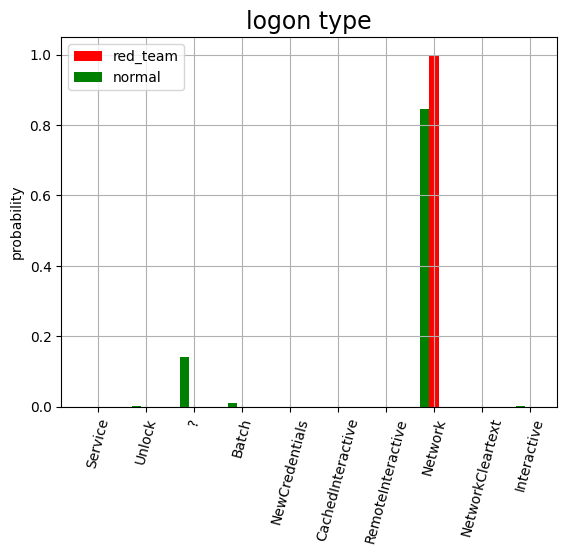

In [192]:
normalized_red_team_d = rt_united_logon_type_counter['red_team_event']
normalized_normal_d = rt_united_logon_type_counter['normal']
plt.grid(True)
align_plot_two_dicts(normalized_red_team_d, normalized_normal_d, 
                 d1_name = 'red_team', d2_name='normal', 
                 plot_title=f'logon type')

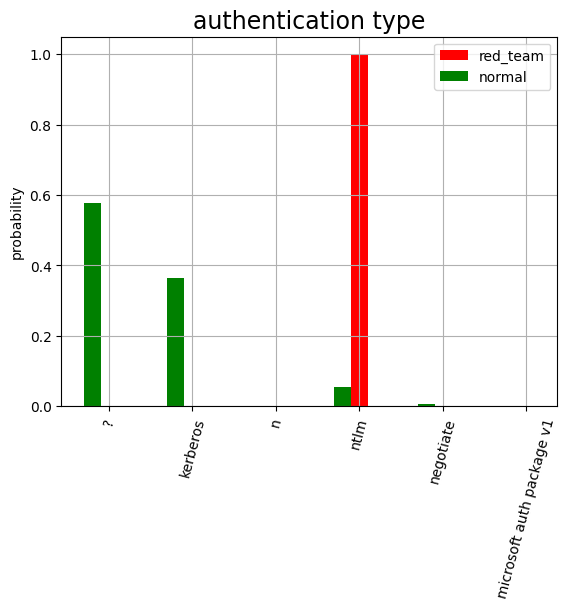

In [195]:
normalized_red_team_d = normalize_dict(rt_united_authentication_type_counter['red_team_event'])
normalized_normal_d = normalize_dict(rt_united_authentication_type_counter['normal'])
plt.figure()
plt.grid(True)
align_plot_two_dicts(normalized_red_team_d, normalized_normal_d, 
                     d1_name = 'red_team', d2_name='normal', 
                     plot_title=f'authentication type')

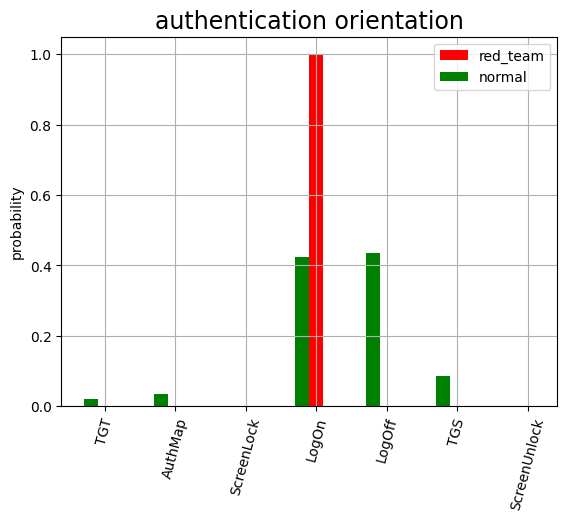

In [196]:
normalized_red_team_d = normalize_dict(rt_united_authentication_orientation_counter['red_team_event'])
normalized_normal_d = normalize_dict(rt_united_authentication_orientation_counter['normal'])
plt.figure()
plt.grid(True)
align_plot_two_dicts(normalized_red_team_d, normalized_normal_d, 
                     d1_name = 'red_team', d2_name='normal', 
                     plot_title=f'authentication orientation')

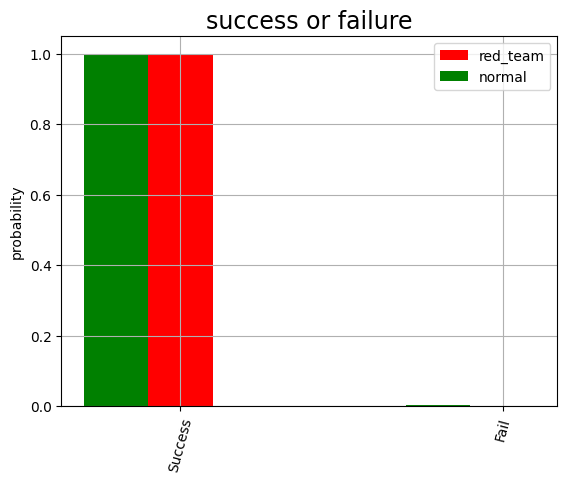

{'red_team_event': {'Success': 0.9985754985754985, 'Fail': 0.0014245014245014246}, 'normal': {'Success': 0.9981021664905896, 'Fail': 0.0018978335094104219}}


In [201]:
normalized_red_team_d = normalize_dict(rt_united_success_counter['red_team_event'])
normalized_normal_d = normalize_dict(rt_united_success_counter['normal'])
plt.figure()
plt.grid(True)
align_plot_two_dicts(normalized_red_team_d, normalized_normal_d, 
                     d1_name = 'red_team', d2_name='normal', 
                     plot_title=f'success or failure')

print(rt_united_success_counter)

In [199]:
# normalized_red_team_d = normalize_dict(rt_united_destination_computer_counter['red_team_event'])
# normalized_normal_d = normalize_dict(rt_united_destination_computer_counter['normal'])
# plt.figure()
# plt.grid(False)
# align_plot_two_dicts(normalized_red_team_d, normalized_normal_d, 
#                  d1_name = 'red_team', d2_name='normal', 
#                  plot_title=f'destination computers')

## Conclusions on red team actions

1. Always LogOn as authentication orientation - makes sense as attackers would prefer to keep logged on
2. Always NLTM as authentication type. Makes sense, because, as chatGPT says, **NTLM is an older authentication protocol used primarily in Windows environments. It's less secure than Kerberos and is being phased out in favor of more secure options.**
3. Always Network as logon type. Makes sense, because, as chatGPT says, **A "Network" logon type is used when a user accesses resources over a network. This can include file shares, printers, or other network resources** - meaning potentially bad intensions of a user
4. Success rate is not indicative 